# CS760 HW3 CODE
**Author: Jiahui Zhang**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

root = 'D:\\LIFE\\WORK\\5-Doctorate\\Coursework\\CS 760\\hw_CS760_Jiahui Zhang\\CS760_HW3\\'

In [ ]:
# read in D2z.txt
def read_dat(path):
    y = []
    x = []
    with open(path,'r') as f:
        for line in f:
            line = line.replace('\n','').split(' ')
            x1, x2, current_y = float(line[0]), float(line[1]), int(line[2])
            assert current_y in [0,1]
            x.append([x1,x2])
            y.append(current_y)
    y = np.array(y)
    x = np.array(x)
    return x,y

# calculate euclidean distance
def cal_distance(dp1,dp2):
    p = len(dp1)
    res = 0
    for pp in range(p):
        res += (dp1[pp]-dp2[pp]) ** 2
    res = np.sqrt(res)
    return res

# KNN for predicting single test point x
def knn(k,train_x,train_y,indiv_test_x):
    dist_list = []
    for tx in train_x:
        dist_list.append(cal_distance(indiv_test_x,tx))
    dist_list = np.array(dist_list)
    sorted_index = np.argsort(dist_list)
    candidate_y_list = train_y[sorted_index[:k]]
    ctr = Counter(candidate_y_list)
    if len(ctr) == 1:
        return list(ctr.keys())[0]
    if ctr[0] > ctr[1]:
        return 0
    elif ctr[1] > ctr[0]:
        return 1
    else:
        return int(np.random.choice([0,1],1))



In [ ]:
x,y = read_dat(path=root+'data\\D2z.txt')

plt.figure()
x1_list_red = []
x2_list_red = []
x1_list_blue = []
x2_list_blue = []
for x1 in np.linspace(-2,2,41):
    for x2 in np.linspace(-2,2,41):
        test_x = [x1,x2]
        pred_y = knn(1,x,y,test_x)
        if pred_y == 1:
            x1_list_red.append(x1)
            x2_list_red.append(x2)
        else:
            x1_list_blue.append(x1)
            x2_list_blue.append(x2)
plt.scatter(x1_list_red,x2_list_red,c='salmon',s=10)
plt.scatter(x1_list_blue,x2_list_blue,c='lightblue',s=10)
indices_pos = [i for i in range(len(y)) if y[i] == 1]
indices_neg = [i for i in range(len(y)) if y[i] == 0]
plt.scatter(x[indices_pos,0],x[indices_pos,1],c='black',marker='+')
plt.scatter(x[indices_neg,0],x[indices_neg,1],marker='o',facecolors='none',edgecolors='black')
plt.show()


In [ ]:
# read in emails.csv
def read_email(path):
    y = []
    x = []
    with open(path,'r') as f:
        for line in f:
            if 'Prediction' in line:
                continue
            line = line.replace('\n','').split(',')[1:]
            current_y = int(line[-1])
            line = line[:-1]
            current_x = []
            for item in line:
                current_x.append(int(item))
            assert current_y in [0,1]
            x.append(current_x)
            y.append(current_y)
    y = np.array(y)
    x = np.array(x)
    return x,y

In [ ]:
x,y = read_email(path=root+'data\\emails.csv')
# data standardization
x = (x-x.mean(0))/x.std(0)

In [ ]:
def sigmoid_func(z):
    if z <= -100:
        return 0
    return 1/(1+np.exp(-z))

def logistic_train(x,y,eta):
    p = len(x[0,:])
    n = len(x[:,0])
    assert n == len(y)
    theta = np.random.randn(p)/100
    while(1):
        old_theta = theta
        for index in range(n):
            #rand_index = np.random.choice(list(range(n)),1)
            rand_x, rand_y = x[index,:], y[index]
            current_pred_y = sigmoid_func(theta.dot(rand_x))
            theta = theta - eta * rand_x * (current_pred_y - rand_y)
        if sum(abs(old_theta-theta)) <= 0.1:
            break
    return theta

def logistic_test(x,theta,threshold=0.5):
    pred_y = sigmoid_func(theta.dot(x))
    if pred_y >= threshold:
        return 1
    else:
        return 0

def logistic_prob(x,theta):
    pred_y = sigmoid_func(theta.dot(x))
    return pred_y


In [ ]:
def onefold_analysis(index_test,sample_amount,method,n_neighbors=-1,threshold=0.5):
    index_train = [i for i in range(sample_amount) if i not in index_test]
    train_x = x[index_train,:]
    train_y = y[index_train]
    true_y = y[index_test]
    pred_y = []
    if method == 'logistic':
        theta = logistic_train(train_x,train_y,eta=0.1)
    elif method == 'NN':
        neigh = KNeighborsClassifier(n_neighbors)
        neigh.fit(train_x,train_y)
    for indiv_test_x in tqdm(x[index_test,:]):
        if method == 'NN':
            current_pred_y = neigh.predict([indiv_test_x])
        elif method == 'logistic':
            current_pred_y = logistic_test(indiv_test_x,theta,threshold)
        pred_y.append(current_pred_y)
    TP = len([i for i in range(len(true_y)) if true_y[i] == 1 and pred_y[i] == 1])
    FP = len([i for i in range(len(true_y)) if true_y[i] == 0 and pred_y[i] == 1])
    FN = len([i for i in range(len(true_y)) if true_y[i] == 1 and pred_y[i] == 0])
    TN = len([i for i in range(len(true_y)) if true_y[i] == 0 and pred_y[i] == 0])
    TOTAL = len(true_y)
    print("ACC: %.4f" % ((TP+TN)/TOTAL))
    print("Precision: %.4f" % (TP/(TP+FP)))
    print("Recal: %.4f" % (TP/(TP+FN)))
    return (TP+TN)/TOTAL



In [ ]:
np.random.seed(5)
for k in [1,3,5,7,10]:
    acc_list = []
    acc_list.append(onefold_analysis(list(range(1000)),5000,'NN',k))
    acc_list.append(onefold_analysis(list(range(1000,2000)),5000,'NN',k))
    acc_list.append(onefold_analysis(list(range(2000,3000)),5000,'NN',k))
    acc_list.append(onefold_analysis(list(range(3000,4000)),5000,'NN',k))
    acc_list.append(onefold_analysis(list(range(4000,5000)),5000,'NN',k))
    print("K=%d, AVG ACC=%.4f" % (k,np.mean(acc_list)))

In [ ]:
np.random.seed(5)
_ = onefold_analysis(list(range(1000)),5000,'logistic')
_ = onefold_analysis(list(range(1000,2000)),5000,'logistic')
_ = onefold_analysis(list(range(2000,3000)),5000,'logistic')
_ = onefold_analysis(list(range(3000,4000)),5000,'logistic')
_ = onefold_analysis(list(range(4000,5000)),5000,'logistic')

In [ ]:
plt.figure()
ks = [1,3,5,7,10]
accs = [0.8492,0.8216,0.8040,0.7796,0.7584]
plt.plot(ks,accs)
plt.title('kNN Five-fold Cross Validation')
plt.ylabel('Average Accuracy')
plt.xlabel('k')
plt.show()

In [114]:
def onefold_analysis_roc(index_test,sample_amount,method,n_neighbors=-1):
    index_train = [i for i in range(sample_amount) if i not in index_test]
    train_x = x[index_train,:]
    train_y = y[index_train]
    pred_y = []
    if method == 'logistic':
        theta = logistic_train(train_x,train_y,eta=0.1)
    elif method == 'NN':
        neigh = KNeighborsClassifier(n_neighbors)
        neigh.fit(train_x,train_y)
    for indiv_test_x in tqdm(x[index_test,:]):
        if method == 'NN':
            current_pred_y = neigh.predict_proba([indiv_test_x])
            pred_y.append(current_pred_y[0,1])
        elif method == 'logistic':
            current_pred_y = logistic_prob(indiv_test_x,theta)
            pred_y.append(current_pred_y)
    return pred_y

In [ ]:
np.random.seed(5)
index_test = list(range(1000))
index_train = [i for i in range(5000) if i not in index_test]
train_x = x[index_train,:]
train_y = y[index_train]
true_y = y[index_test]
pred_y = onefold_analysis_roc(index_test,5000,'NN',5)


In [118]:
fpr_knn, tpr_knn, thres_knn = roc_curve(true_y,pred_y)
auc_knn = auc(fpr_knn,tpr_knn)

In [115]:
pred_y_logi = onefold_analysis_roc(index_test,5000,'logistic')


100%|██████████| 1000/1000 [00:00<00:00, 166678.75it/s]


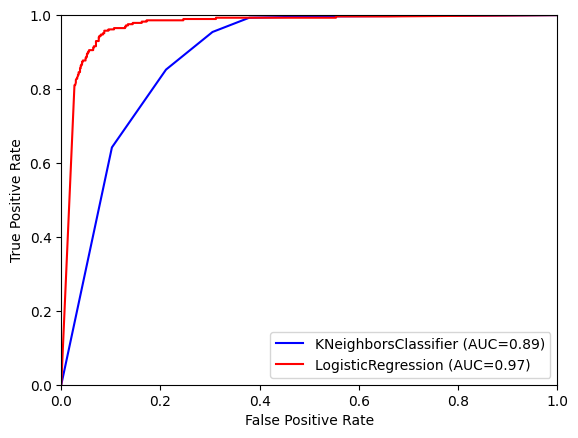

In [122]:
fpr_logi, tpr_logi, thres_logi = roc_curve(true_y,pred_y_logi)
auc_logi = auc(fpr_logi,tpr_logi)

plt.figure()
plt.plot(fpr_knn,tpr_knn,'b',label='KNeighborsClassifier (AUC=%.2f)' % auc_knn)
plt.plot(fpr_logi,tpr_logi,'r',label='LogisticRegression (AUC=%.2f)' % auc_logi)
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
